In [1]:
# https://www.kaggle.com/code/fumitakahashi/time-series-data-with-arima-model

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

In [3]:
train = pd.read_csv("/Users/elena/Downloads/train_1.csv")

In [4]:
train.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 551 entries, Page to 2016-12-31
dtypes: float64(550), object(1)
memory usage: 609.8+ MB


Data consists of the name of each Wikipedia page and the days views were recorded. PAGE/YYYY-MM-DD (2015-07-01 - 2016-12-31, 550 days in total)

MISSING DATA

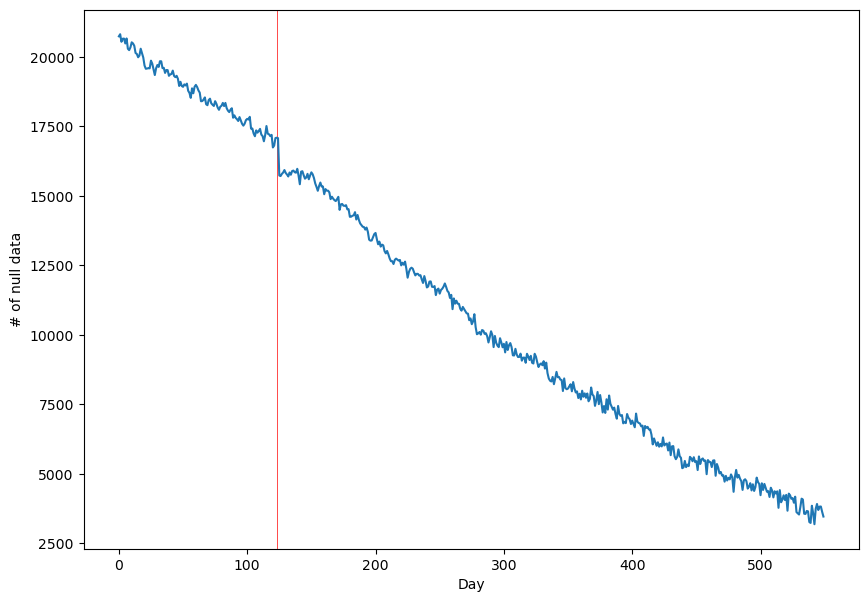

In [8]:
days = [r for r in range(train.shape[1] - 1)]
fig, ax = plt.subplots(figsize = (10,7))
plt.xlabel('Day')
plt.ylabel('# of null data')
ax.axvline(x=123, c = 'red',  lw = 0.5)
plt.plot(days, train.iloc[:,1:].isnull().sum())
plt.show()

In [9]:
train.columns[123]

'2015-10-31'

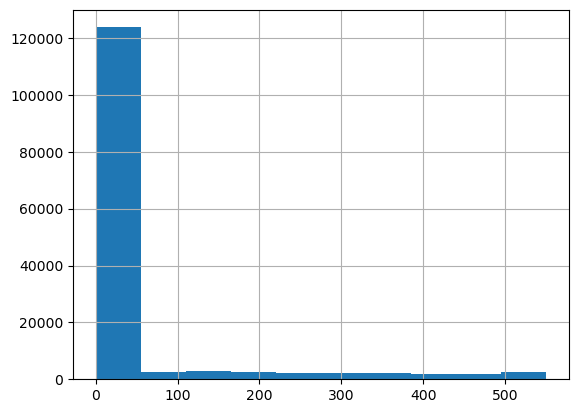

In [10]:
# Histogram of pages with their number of data missing. 

train.isnull().sum(axis = 1).hist()
plt.show()

Lots of null data in the beggining, but decreases as the time goes.
Perhaps, some pages were newly created?
However, many pages have no missing data as seen from the second diagram.
Filling with 0 as it makes it easier to continue.

In [12]:
train = train.fillna(0)

Feature Engineering

In [14]:
train.Page

0                   2NE1_zh.wikipedia.org_all-access_spider
1                    2PM_zh.wikipedia.org_all-access_spider
2                     3C_zh.wikipedia.org_all-access_spider
3                4minute_zh.wikipedia.org_all-access_spider
4         52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...
                                ...                        
145058    Underworld_(serie_de_películas)_es.wikipedia.o...
145059    Resident_Evil:_Capítulo_Final_es.wikipedia.org...
145060    Enamorándome_de_Ramón_es.wikipedia.org_all-acc...
145061    Hasta_el_último_hombre_es.wikipedia.org_all-ac...
145062    Francisco_el_matemático_(serie_de_televisión_d...
Name: Page, Length: 145063, dtype: object

In [15]:
import re
def split_page(page):
  w = re.split(r'_|\.', page)
  return ' '.join(w[:-5]), w[-5], w[-2], w[-1]

li = list(train.Page.apply(split_page))
df = pd.DataFrame(li)
df.columns = ['Title', 'Language', 'Access_type','Access_origin']
df = pd.concat([train, df], axis = 1)
del df['Page']

In [16]:
df.iloc[:, -4:]

,Title,Language,Access_type,Access_origin
0,2NE1,zh,all-access,spider
1,2PM,zh,all-access,spider
2,3C,zh,all-access,spider
3,4minute,zh,all-access,spider
4,52 Hz I Love You,zh,all-access,spider
...,...,...,...,...
145058,Underworld (serie de películas),es,all-access,spider
145059,Resident Evil: Capítulo Final,es,all-access,spider
145060,Enamorándome de Ramón,es,all-access,spider
145061,Hasta el último hombre,es,all-access,spider


Okay, so now the Page name is split into

Title (title of the page)
Language (languaeg written with)
Access_type (the type of access) *Acceess_origin (the type of access)

In [18]:
df[df.Language == 'de'].iloc[:,-4:]

,Title,Language,Access_type,Access_origin
46371,10 Cloverfield Lane,de,all-access,spider
46372,11 November,de,all-access,spider
46373,12 Monkeys,de,all-access,spider
46374,187 Strassenbande,de,all-access,spider
46375,1944 (Lied),de,all-access,spider
...,...,...,...,...
141521,Anschlag auf den Berliner Weihnachtsmarkt an d...,de,all-access,all-agents
141522,Hacksaw Ridge – Die Entscheidung,de,all-access,all-agents
141523,Flugunfall der KLM Fokker F XXII „Kwikstaart“,de,all-access,all-agents
141524,Winnetou – Der Mythos lebt,de,all-access,all-agents


<Axes: xlabel='Language'>

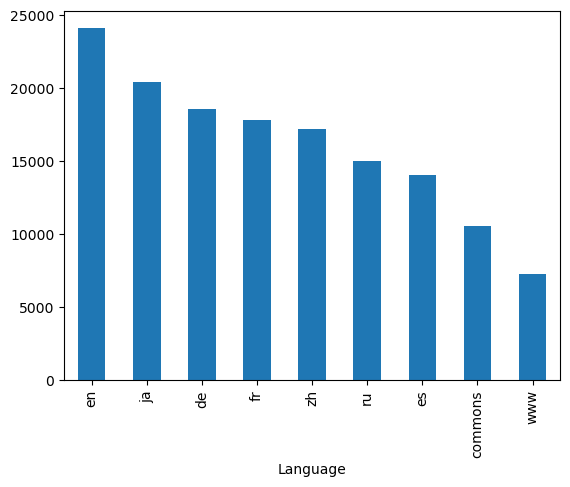

In [19]:
df.Language.value_counts().plot(kind = 'bar')

There are actually pages with unspecific languages: commons and www.
Others are English, Japanese, German, French, Chinese, Russian, Spanish

<Axes: xlabel='Access_type'>

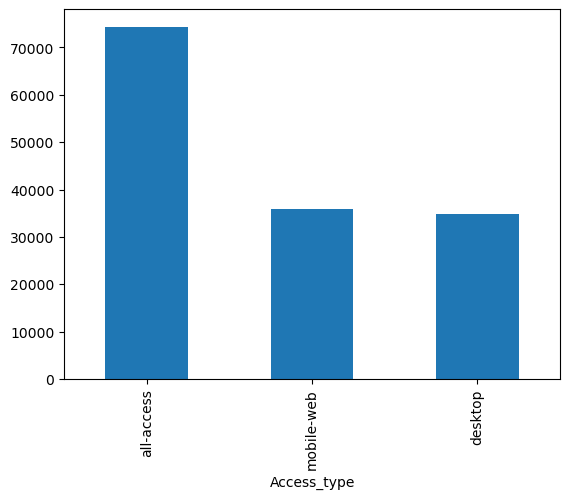

In [21]:
df.Access_type.value_counts().plot(kind = 'bar')

There are three types of access: all-access, mobike, and desktop

<Axes: xlabel='Access_origin'>

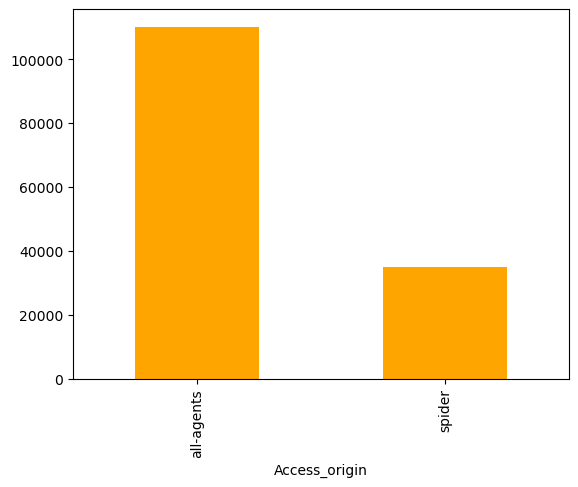

In [23]:
df.Access_origin.value_counts().plot(kind = 'bar', color = 'orange')

The acess origins are either all-agents or spider.
Okay, so now we have global categorical features. Let's take a look at the time series data.

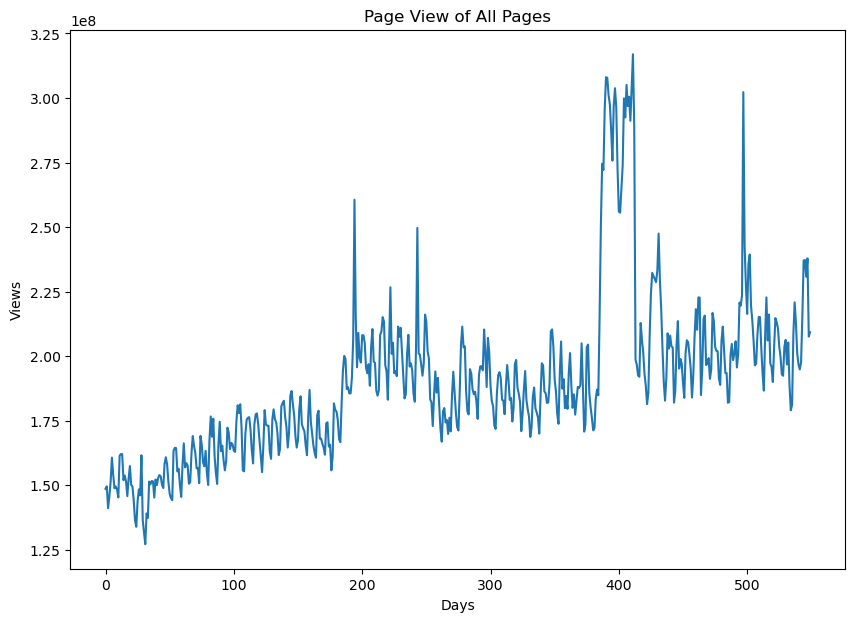

In [25]:
sum_all = df.iloc[:,:-4].sum(axis = 0)

days = list(r for r in range(sum_all.shape[0]))

fig = plt.figure(figsize = (10, 7))
plt.xlabel('Days')
plt.ylabel('Views')
plt.title('Page View of All Pages')
plt.plot(days, sum_all)

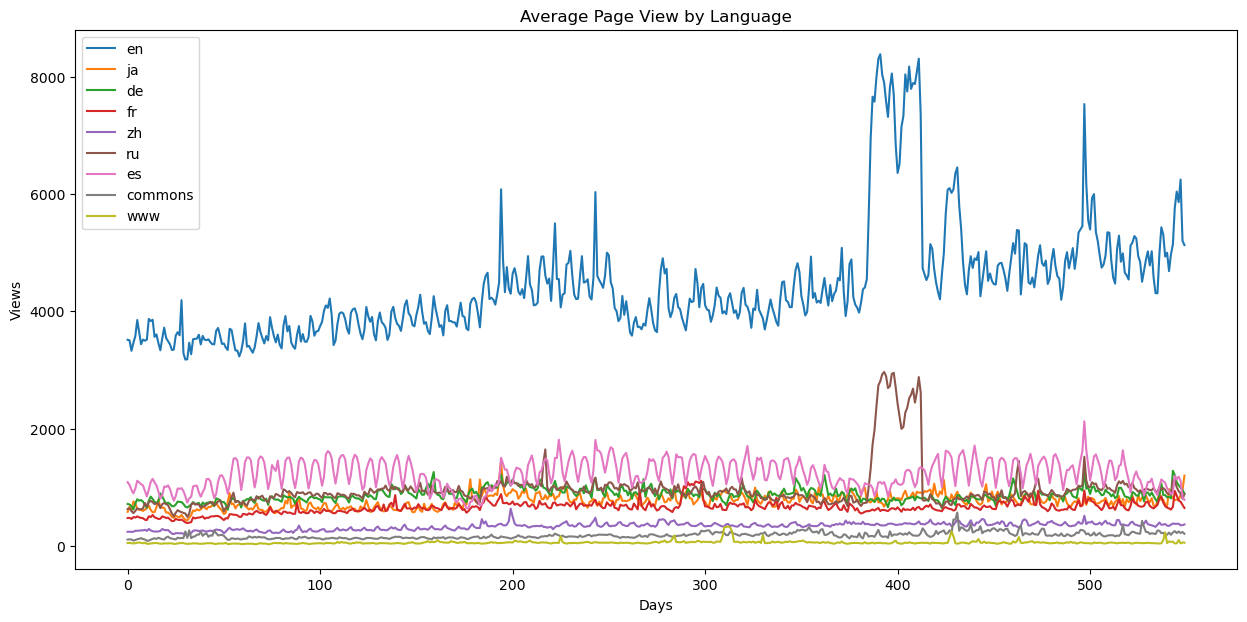

In [26]:
summap = {}
lang_list = ["en", "ja", "de", "fr", "zh", "ru", "es", "commons", "www"]
for l in lang_list:
  summap[l] = df[df.Language == l].iloc[:,:-4].sum(axis = 0)/df[df.Language == l].shape[0]

fig = plt.figure(figsize = (15, 7))
plt.xlabel('Days')
plt.ylabel('Views')
plt.title('Average Page View by Language')

for key in summap:
  plt.plot(days, summap[key], label = key)
plt.legend()
plt.show()

The overall sum is largelly affected by the English trend.
It is difficult to see the trends of minor languages so I will use Forier Transform.

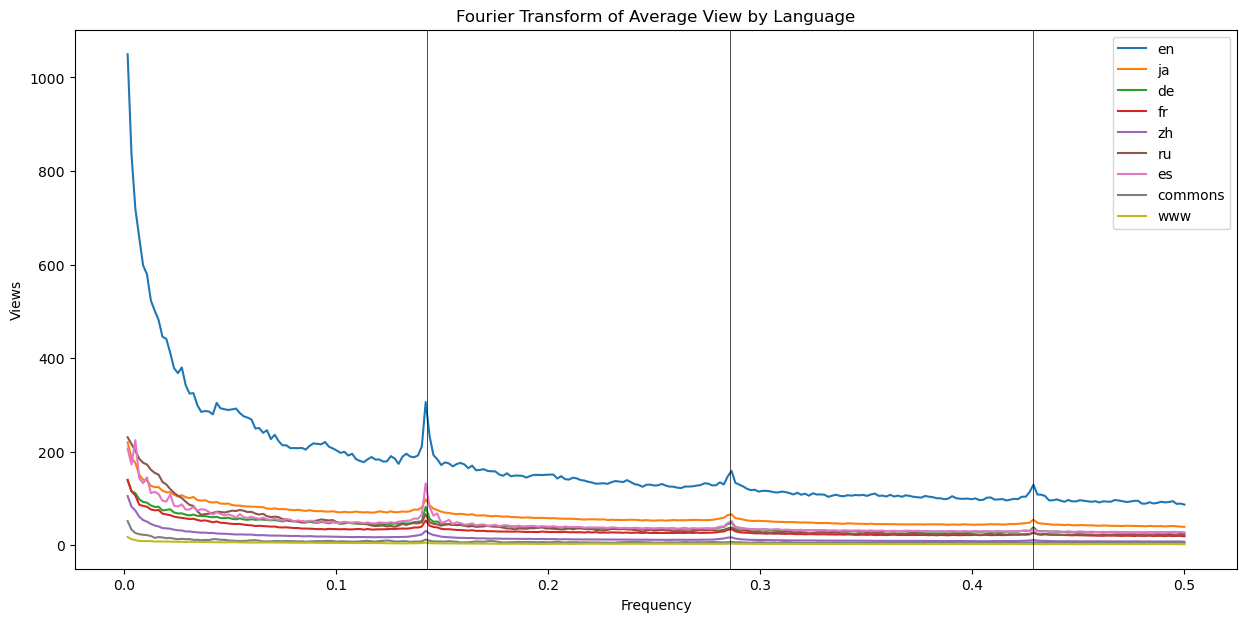

In [28]:
from scipy.fftpack import fft

#data = df.iloc[idx,0:-4]

fig, ax = plt.subplots(figsize = (15, 7))

fftmean = {}
fftxvals = {}

for key in summap:
  fftval = fft(df[df.Language == key].iloc[:, :-6])

#calculate magnitude
  fftmag = [np.sqrt(np.real(x)*np.real(x)+
                    np.imag(x)*np.imag(x)) for x in fftval]
  arr = np.array(fftmag)
#calculate mean
  fftmean[key] = np.mean(arr,axis=0)

  fftxvals[key] = [day/fftmean[key].shape[0] for day in range(fftmean[key].shape[0])]

  npts = len(fftxvals[key])//2 + 1
  fftmean[key] = fftmean[key][:npts]/fftmean[key].shape[0]
  fftxvals[key] = fftxvals[key][:npts]
  ax.plot(fftxvals[key][1:], fftmean[key][1:], label = key)

plt.axvline(x = 1/7, color = 'black', lw = 0.5)
plt.axvline(x = 2/7, color = 'black', lw = 0.5)
plt.axvline(x = 3/7, color = 'black', lw = 0.5)

plt.xlabel('Frequency')
plt.ylabel('Views')
plt.title('Fourier Transform of Average View by Language')

plt.legend()
plt.show()

There are clear peaks at 1/7, 2/7 and 3/7. They are likely to be the weekly trends as we have 7 days per week.
Trends in longer terms (smaller frequency) depend on the language.
Okay, so now I will take a look at individual page. Let's check the most viewed pages for each language.

In [30]:
sums = pd.concat([df.iloc[:,-4:], df.iloc[:,:-4].sum(axis = 1)], axis = 1)
sums.columns = ['Title', 'Language', 'Access_type', 'Access_origin', 'sumvalues']

In [31]:
max_list = {}
for l in lang_list:
  lang_sums = sums[sums.Language == l]
  max_list[l] = lang_sums.sumvalues.idxmax()

In [32]:
df[df.index.isin(max_list.values())].iloc[:,-4:]

,Title,Language,Access_type,Access_origin
20970,MediaWiki,www,all-access,all-agents
27330,Wikipédia:Accueil principal,fr,all-access,all-agents
28727,Wikipedia:首页,zh,all-access,all-agents
38573,Main Page,en,all-access,all-agents
45071,Special:Search,commons,all-access,all-agents
92205,Wikipedia:Portada,es,all-access,all-agents
99322,Заглавная страница,ru,all-access,all-agents
120336,メインページ,ja,all-access,all-agents
139119,Wikipedia:Hauptseite,de,all-access,all-agents


The most viewed pages are the main portal pages of Wikipedia.

In [34]:
import matplotlib as mpl

mpl.rcParams['font.family'] = 'AppleGothic'

def plot_trend(lang, idx):
    fig = plt.figure(1,figsize=(10,5))
    plt.plot(days, df.iloc[idx,:-4])
    plt.xlabel('day')
    plt.ylabel('views')
    plt.title('Most Viewed Pages ({})'.format(lang))  
    plt.show()

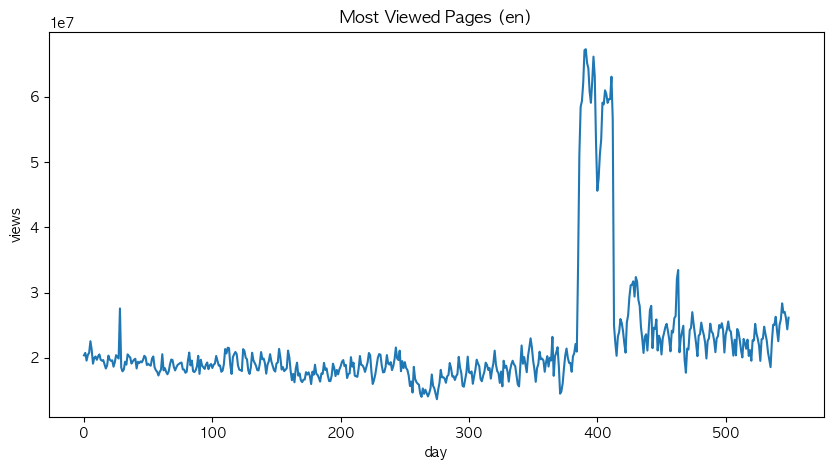

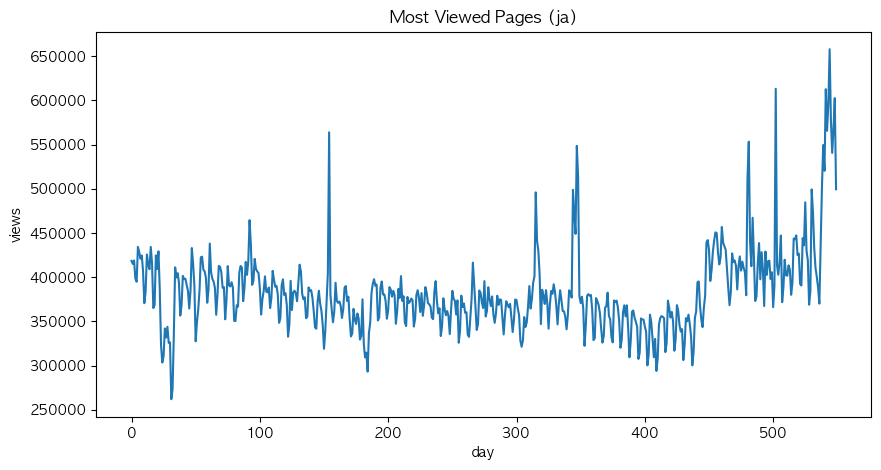

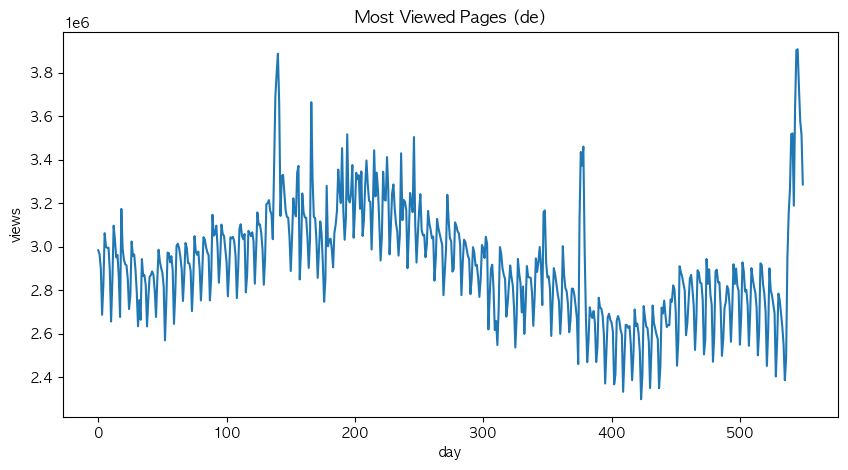

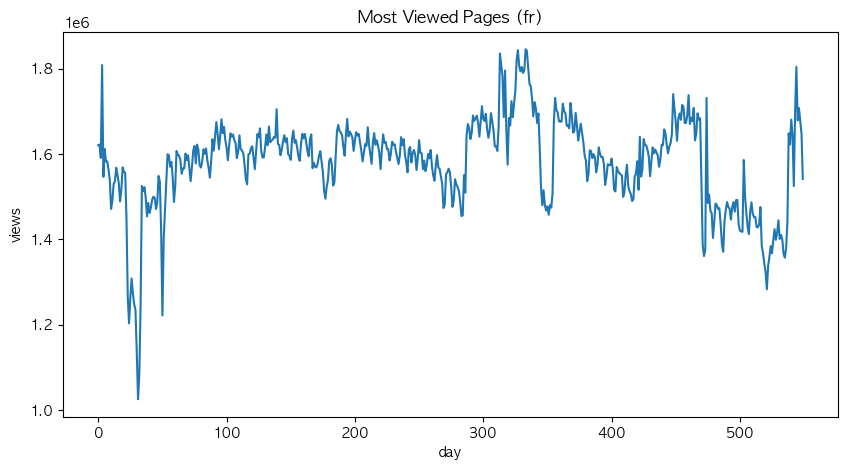

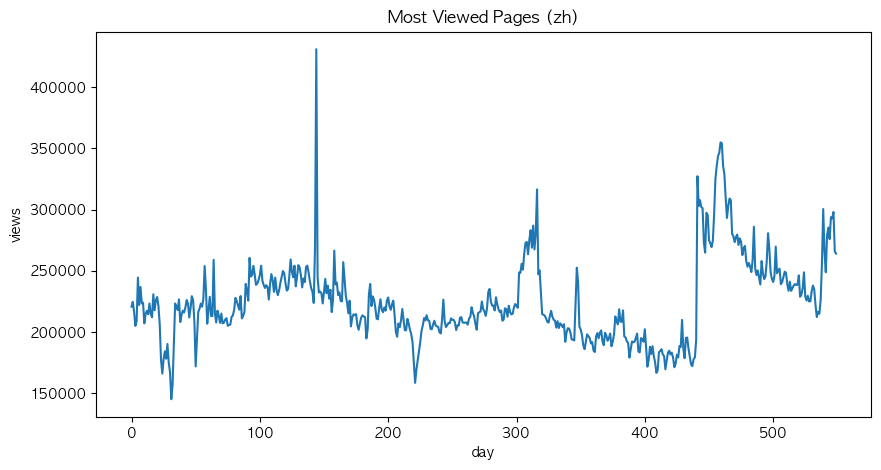

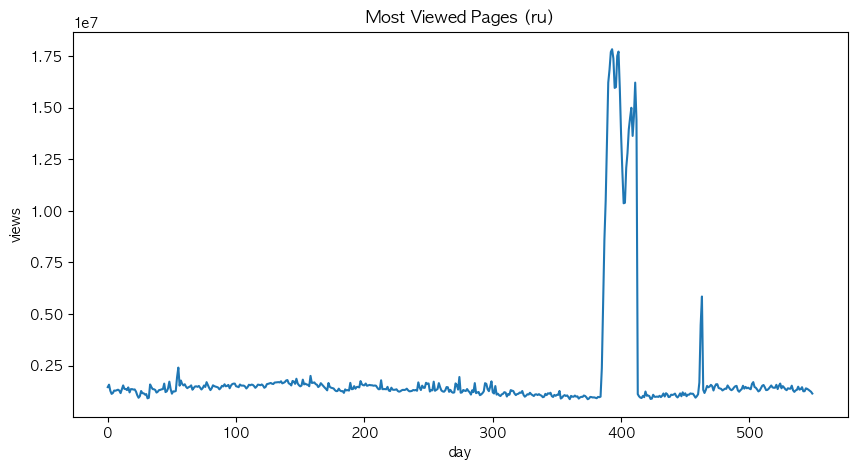

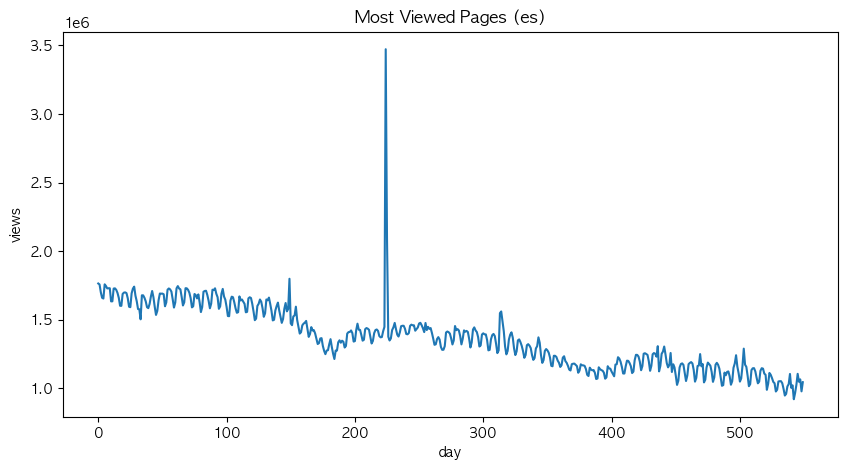

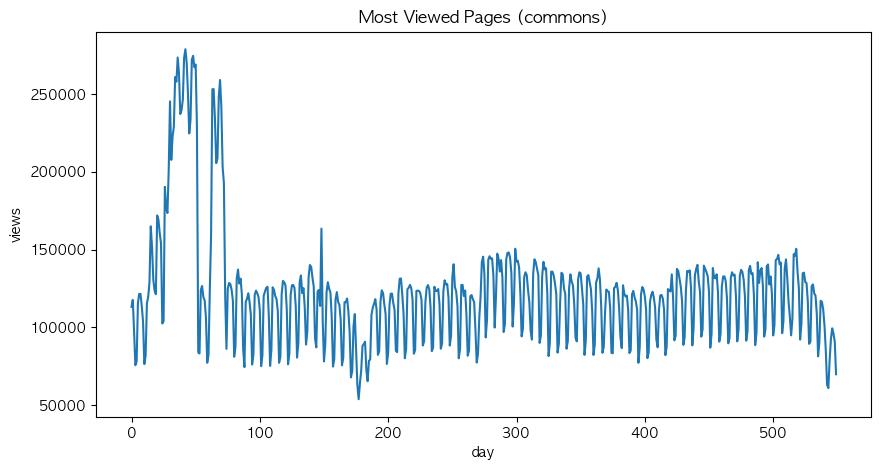

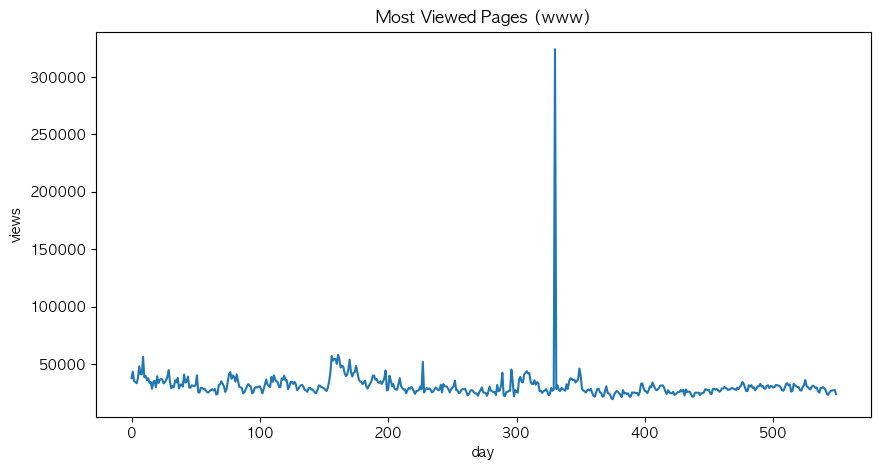

In [35]:
for key in max_list:
  plot_trend(key, max_list[key])

Each page has unique trend features.
There are some weird spikes as well.
OK, so what about the second largest?

In [37]:
sums2 = sums.drop(labels = max_list.values(), axis = 0)
max_list2 = {}
for l in lang_list:
  lang_sums = sums2[sums2.Language == l]
  max_list2[l] = lang_sums.sumvalues.idxmax()
  
df[df.index.isin(max_list2.values())].iloc[:,-4:]

,Title,Language,Access_type,Access_origin
9774,Main Page,en,desktop,all-agents
43468,MediaWiki,www,desktop,all-agents
55104,Wikipédia:Accueil principal,fr,mobile-web,all-agents
61350,Wikipedia:首页,zh,desktop,all-agents
81665,Special:Search,commons,desktop,all-agents
86431,メインページ,ja,desktop,all-agents
95855,Wikipedia:Portada,es,mobile-web,all-agents
103123,Заглавная страница,ru,desktop,all-agents
116196,Wikipedia:Hauptseite,de,mobile-web,all-agents


The second most viewed ones are from main pages in different access types.
Let's compare the trend by their access type then.
Why don't we compare the access type to see if there is any difference?

In [39]:
main_titles = dict(zip(list(df[df.index.isin(max_list.values())].Language), list(df[df.index.isin(max_list.values())].Title)))

all_access = {}
mobile_access = {}
desktop_access = {}

for l in lang_list:
  all_access[l] = df.index[(df.Language == l) & (df.Title == main_titles[l]) & (df.Access_type == 'all-access')]
  mobile_access[l] = df.index[(df.Language == l) & (df.Title == main_titles[l]) & (df.Access_type == 'mobile-web')]
  desktop_access[l] = df.index[(df.Language == l) & (df.Title == main_titles[l]) & (df.Access_type == 'desktop')]

In [40]:
def plot_trend_access_type(lang):

    plt.figure(figsize=(15,4))

    plt.subplot(1,3, 1)
    plt.plot(days, df.iloc[all_access[l][0],:-4])
    plt.title('All Access ({})'.format(lang))
    plt.subplot(1,3, 2)
    plt.plot(days, df.iloc[mobile_access[l][0],:-4])
    plt.title('Mobile-web Access ({})'.format(lang))
    plt.subplot(1,3, 3)
    plt.plot(days, df.iloc[desktop_access[l][0],:-4])
    plt.title('Desktop Access ({})'.format(lang))
    plt.show()

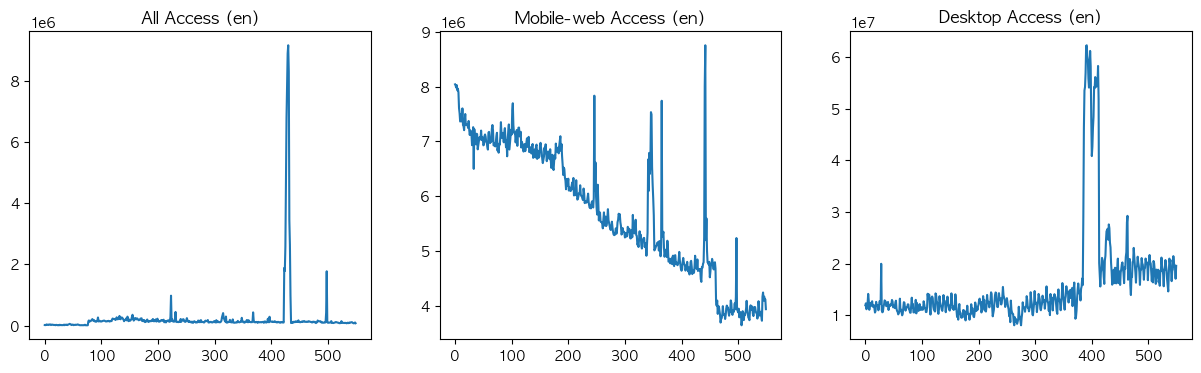

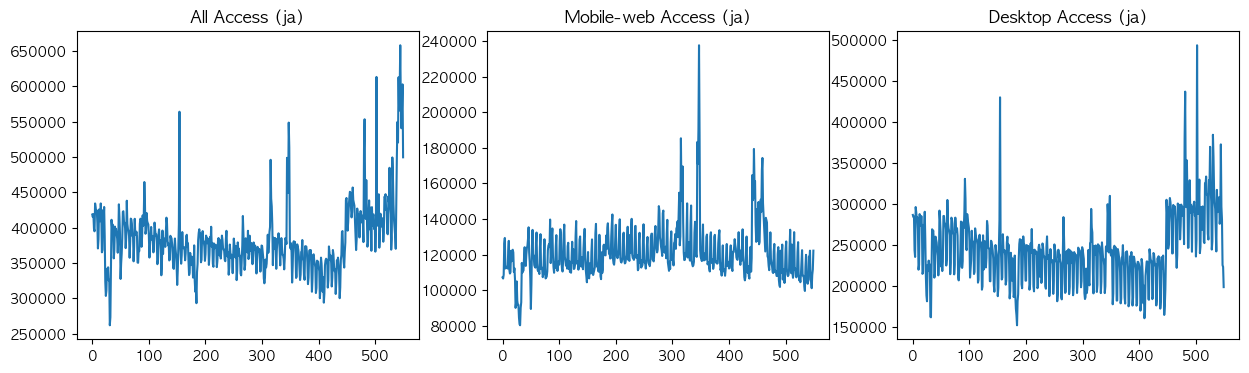

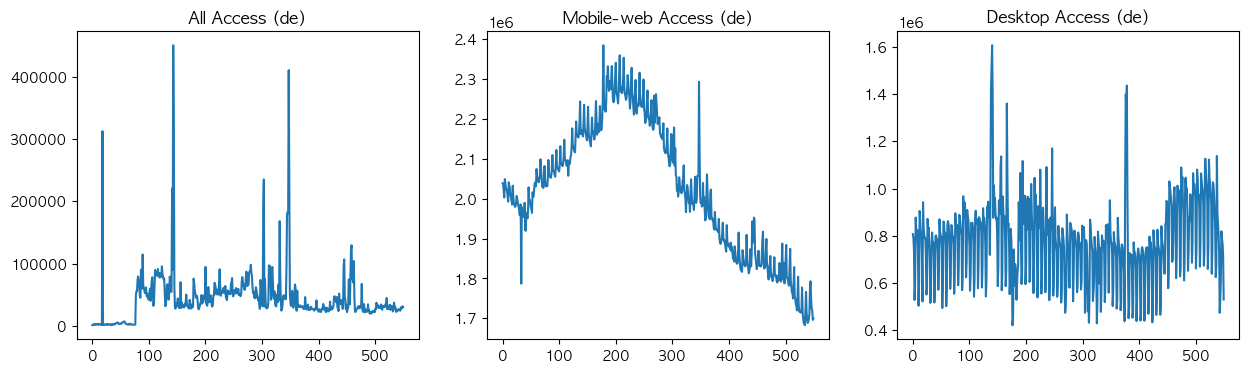

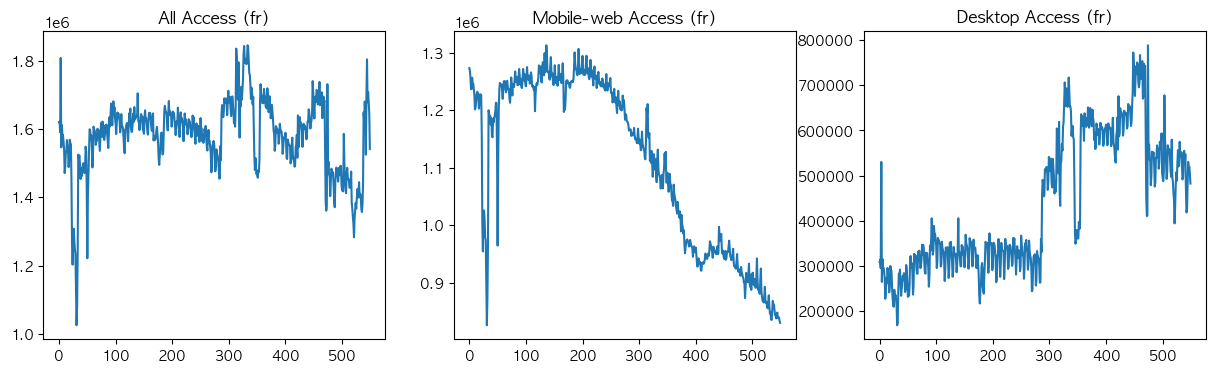

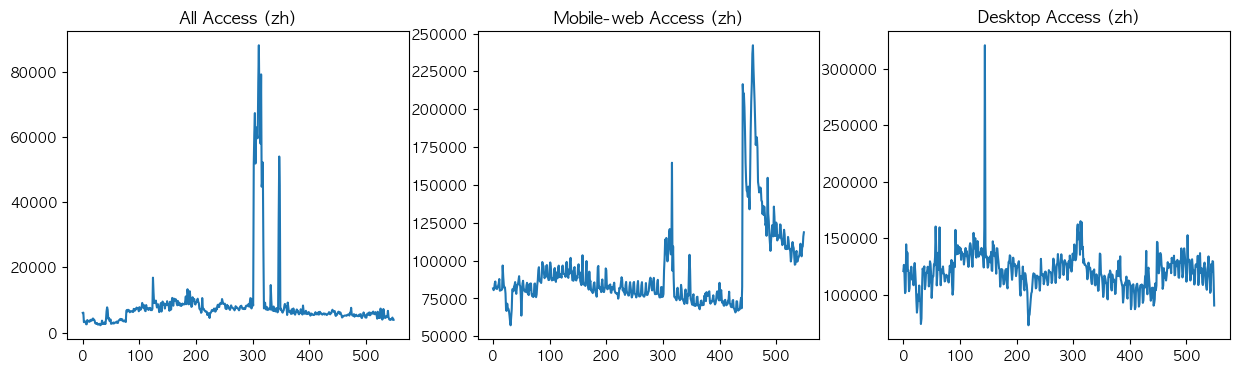

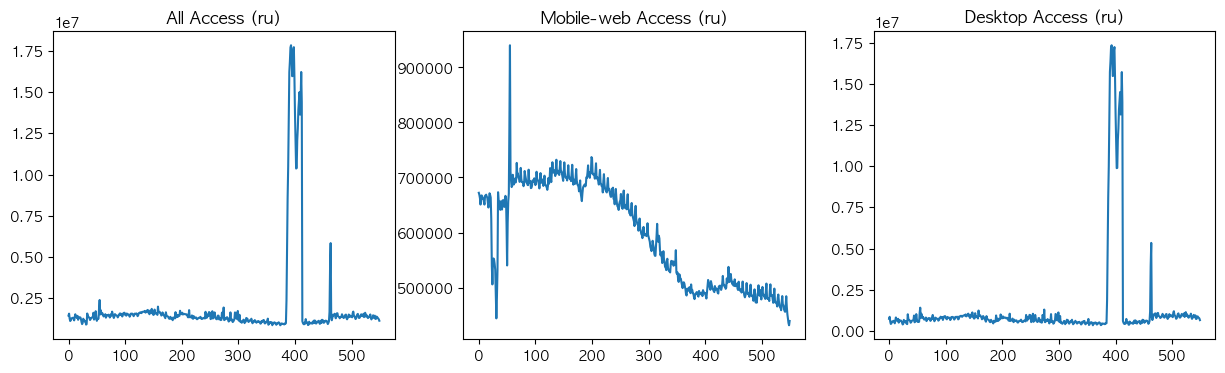

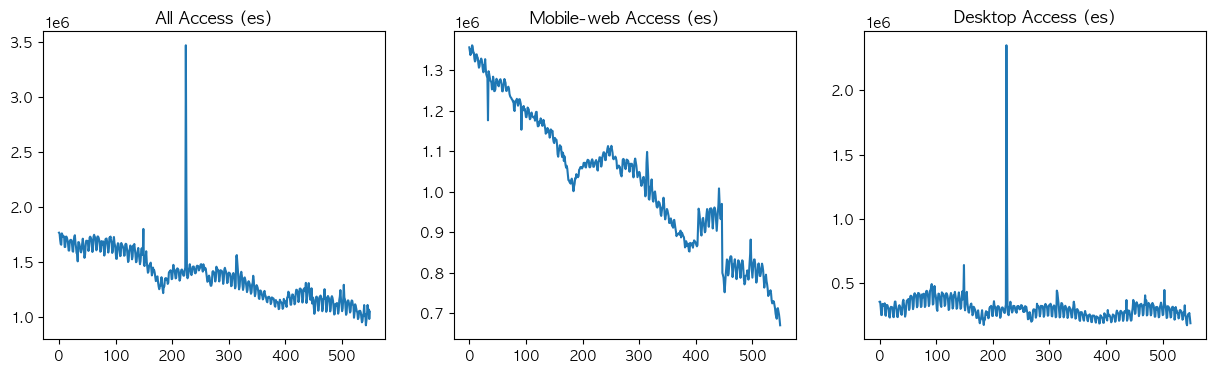

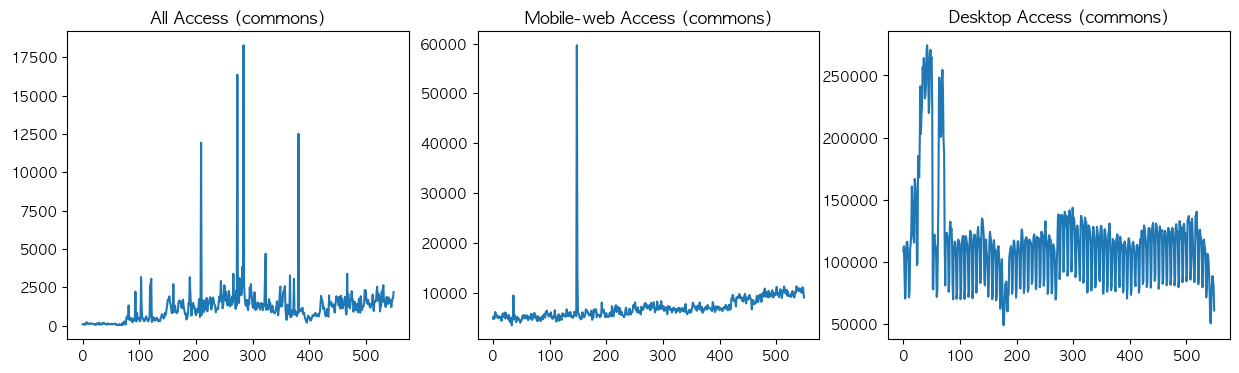

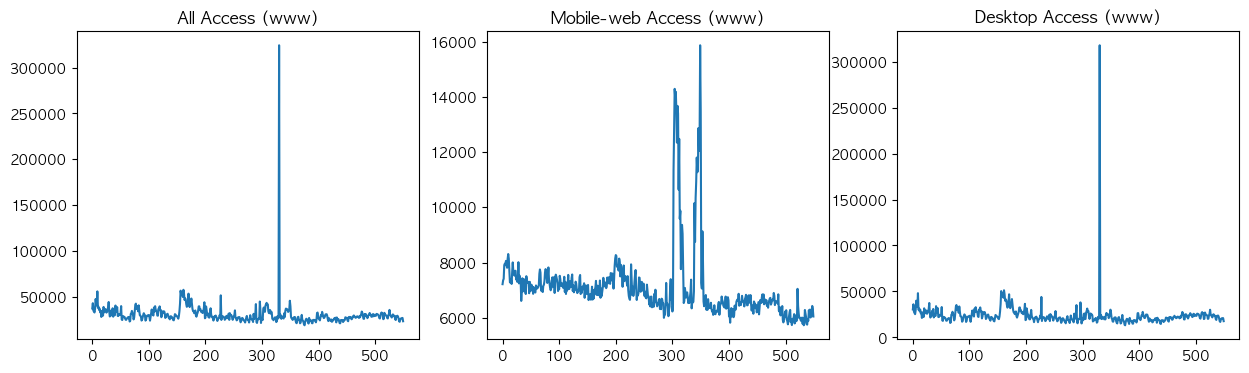

In [41]:
for l in lang_list:
  plot_trend_access_type(l)

The shapes of the graphs differ a lot depending on the access type.
In most of the languages, there are peaks around 300th days, which could be because of the 2016 summer Olympics from Rio.
For the case of English, Japanese and French, there are overall decrease in Mobile Access but increase in Desktop Access for some reason...
Possible reasons could be... mobile users shifted to desktop? Was there new macbook released? Or mobile wikipedia degraded?

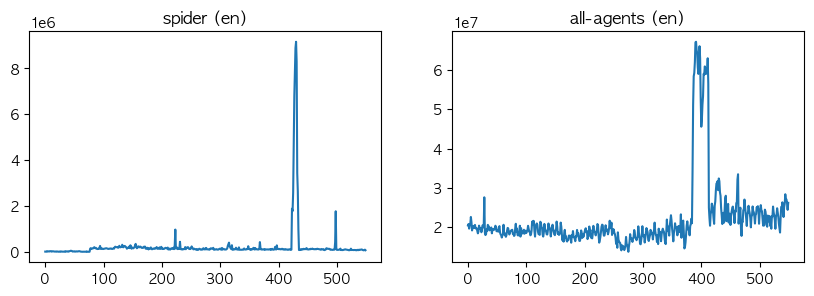

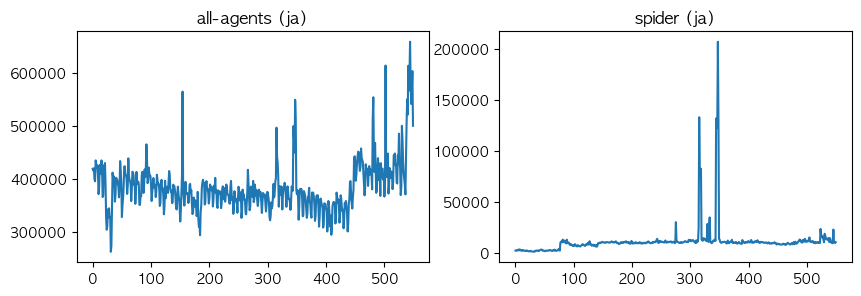

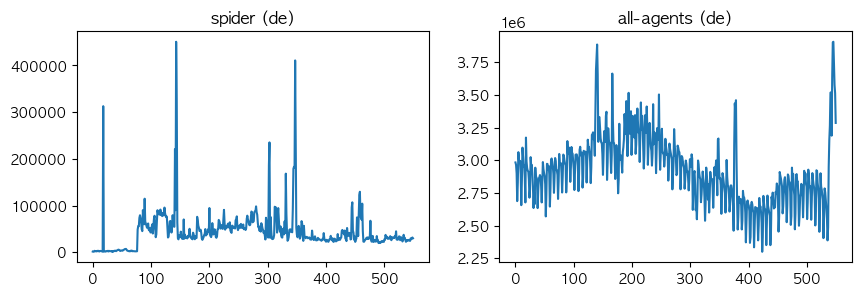

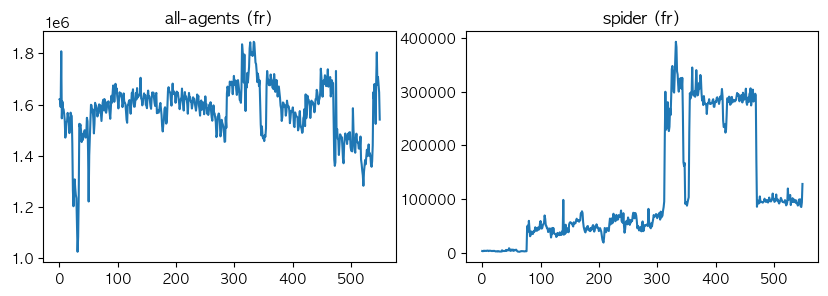

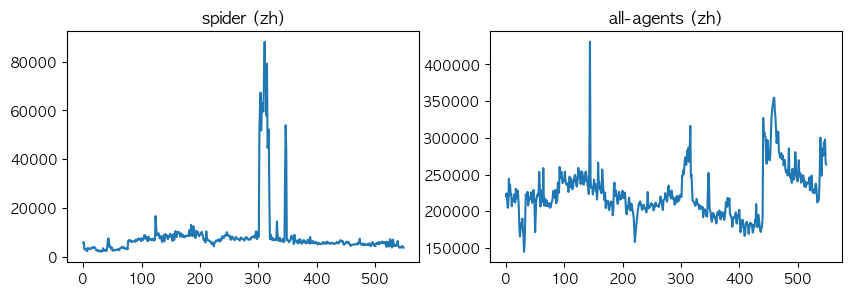

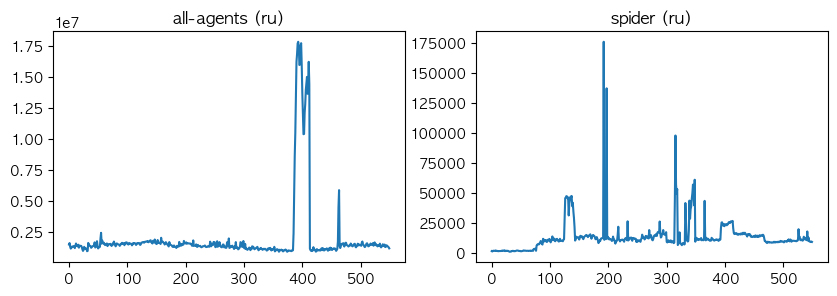

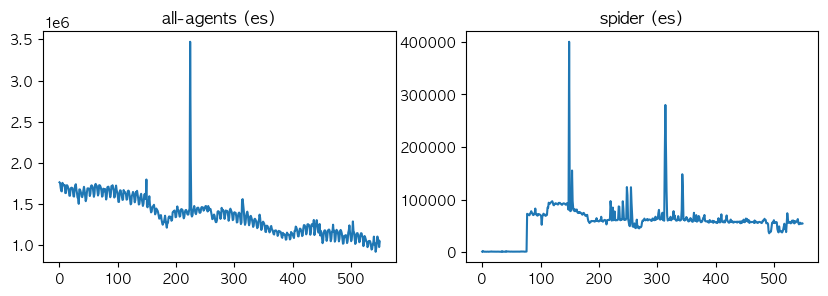

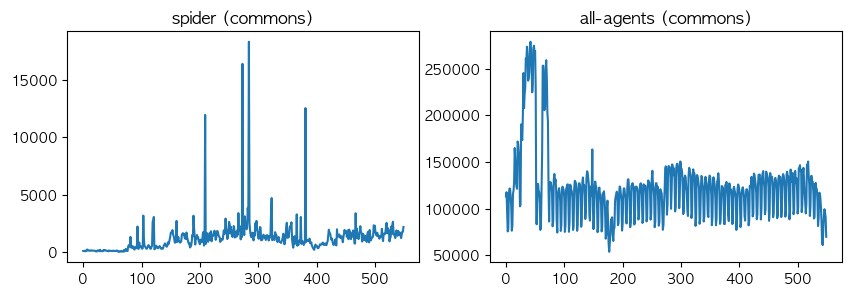

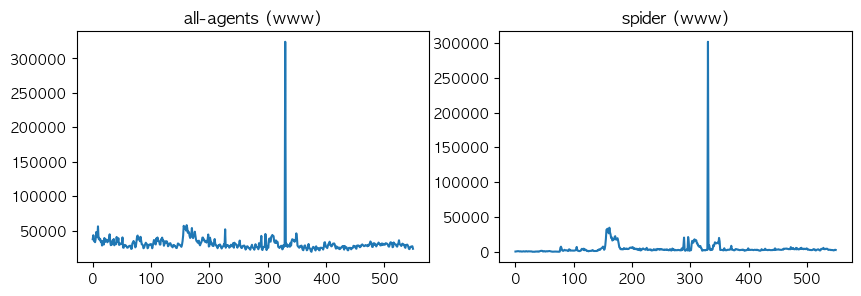

In [43]:
def plot_trend_access_origin(lang):

    plt.figure(figsize=(10,3))

    plt.subplot(1,2, 1)
    plt.plot(days, df.iloc[all_access[l][0],:-4])
    plt.title('{} ({})'.format(df.iloc[all_access[l][0],:].Access_origin,lang))
    plt.subplot(1,2, 2)
    plt.plot(days, df.iloc[all_access[l][1],:-4])
    plt.title('{} ({})'.format(df.iloc[all_access[l][1],:].Access_origin, lang))
    plt.show()
  
for l in lang_list:
    plot_trend_access_origin(l)

Spider seem to be more constant than all-agent. Perhaps, they are less events driven than normal access.


Prediction¶
I will use the first 500 days to predict the last 50 days.

ARIMA
Let's try ARIMA to predict the views from the time series data.



In [46]:
# Split the data into train and test

series = df.iloc[:, 0:-4]

from sklearn.model_selection import train_test_split

X = series.iloc[:,:500]
y = series.iloc[:,500:]

X_train, X_val, y_train, y_val = train_test_split(X.values, y.values, test_size=0.1, random_state=42)

Let's use walk-forward validation technique to see how the ARIMA model learns and predicts. It will take a lot of time to predict all dataset so I will just use the main page in Japanese.

In [48]:
from statsmodels.tsa.arima.model import ARIMA

train, test = X_train[86431], y_train[86431]
record = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	# fit model
	model = ARIMA(record, order=(4,1,0))
	model_fit = model.fit()
	# forecast one step
	yhat = model_fit.forecast()[0]
	# store the result
	predictions.append(yhat)
	record.append(test[t])

RMSE: 5.859


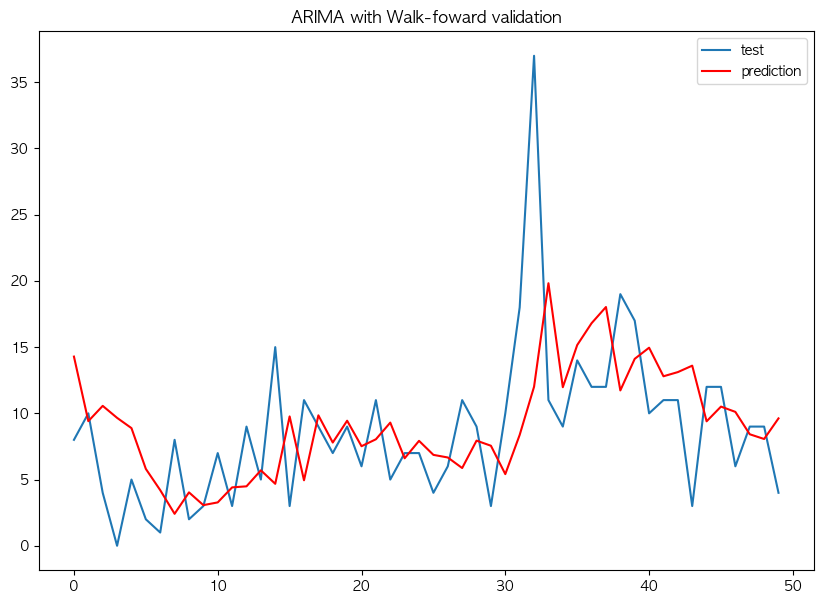

In [49]:
from math import sqrt
from sklearn.metrics import mean_squared_error
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
fig = plt.subplots(figsize=(10,7))
plt.plot(test)
plt.plot(predictions, color='red')
plt.legend(['test', 'prediction'])
plt.title('ARIMA with Walk-foward validation')
plt.show()

Let's see how the parameters p, d, q affect our ARIMA model.

p: Determines the time range to obtain the auto regression (AR)
q: Determines the time range to obtain moving avereage (MV)
d: Determines the level of differentiation.

In [51]:
# evaluate an ARIMA model for a given order (p,d,q) with MSE
def evaluate_arima_model(train, test, arima_order):
	# prepare training dataset
	record = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(record, order=arima_order)
		model_fit = model.fit(disp=0)
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		record.append(test[t])
	# calculate out of sample error
	error = mean_squared_error(test, predictions)
	aic_score= model_fit.aic
	return error, aic_score


import warnings
warnings.filterwarnings("ignore")

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(train, test, p_values, d_values, q_values):
	train, test = train.astype('float32'), test.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse, aic = evaluate_arima_model(train, test, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
						aic_out = aic
					print('ARIMA  ', order,    'MSE=%.3f   AIC=%.3f' % ( mse, aic))
				except:
					continue
	# print('Best ARIMA:    ', best_cfg,  'MSE=%.3f  AIC=%.3f' % (best_cfg, best_score))

In [52]:
p_values = [0, 5]
d_values = range(0, 2)
q_values = range(4, 8)
warnings.filterwarnings("ignore")
evaluate_models(X_train[86431], y_train[86431], p_values, d_values, q_values)

So in general, MSE is smaller at p=0, d=0 and d around 5 to 7.
In deed, the best combination was when p=0,d = 0 and q = 5.

In [54]:
p_values = [0, 1]
d_values = [0,1]
q_values = [5,7]
warnings.filterwarnings("ignore")
evaluate_models(X_train[86431], y_train[86431], p_values, d_values, q_values)

So the best combination was actually 1, 0 ,5.

Let's visualize and compare to the previous result.

RMSE: 5.680


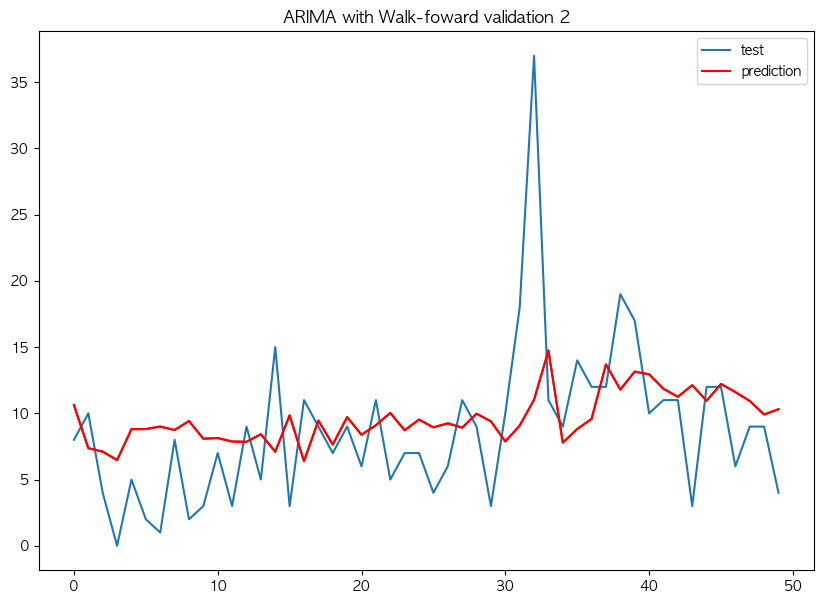

In [57]:
train, test = X_train[86431], y_train[86431]
record = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	# fit model
	model = ARIMA(record, order=(1,0,5))
	model_fit = model.fit()
	# forecast one step
	yhat = model_fit.forecast()[0]
	# store the result
	predictions.append(yhat)
	record.append(test[t])
 
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
fig = plt.subplots(figsize=(10,7))
plt.plot(test)
plt.plot(predictions, color='red')
plt.plot(predictions, color='red')
plt.legend(['test', 'prediction'])
plt.title('ARIMA with Walk-foward validation 2')
plt.show()

So compared to the previous model, the model is not cpaturing the large spikes, but did not cause any huge error either, which is why this model had the lowest MSE.